/Applications/anaconda3/envs/PtClouds/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning:

FixedFormatter should only be used together with FixedLocator



(-0.5, 12.5, 0.5, -0.5)

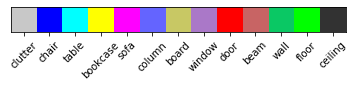

In [1]:
import pickle
from ipyvolume import pylab as pb
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
import pandas as pd
import glob
%matplotlib inline 
color_bar = {'clutter':[200,200,200],'chair':[0,0,255],
                 'table':[0,255,255],
                 'bookcase':[255,255,0],
                 'sofa':[255,0,255],
                 'column':[100,100,255],
                 'board':[200,200,100],
                 'window':[170,120,200],
                 'door':[255,0,0],
                 'beam':[200,100,100],
                 'wall':[10,200,100],
                 'floor':[0,255,0],
                 'ceiling':[50,50,50]} 
col_bar = widgets.Output()
fig, ax = plt.subplots(1,1)
fig.set_size_inches(6, 1.5)
img = plt.imshow(np.expand_dims(np.array([list(color_bar.values())[i] for i in range(13)]),axis=0))
ax.set_xticklabels(color_bar.keys())
plt.xticks(ticks=range(13),rotation=45)
plt.yticks([])
plt.axis('on')

In [2]:
with open('pred_for_dif_rad.pickle','rb') as f:
    pts = pickle.load(f)
    rad_list = pickle.load(f)
with open('test_split.txt','r') as f:
    rooms = f.readlines()

rooms = [ r for r in rooms if 'hallway' not in r and 'WC' not in r and 'storage' not in r]
ori_rooms = rooms
rooms = list(zip(rooms,range(len(rooms))))

In [3]:
x_axis = [int(s)/1000 for s in ['025','050','075','100','125','150','175','200','225','250','300','350','400']]
rad_acc_list = []
conf_mat_list = []
for i in range(len(rad_list)):
    rad_acc_list.append((np.sum(np.concatenate(pts['gt'],axis=0)==np.concatenate(rad_list[i],axis=0))/np.concatenate(pts['gt'],axis=0).shape[0],np.histogram(np.concatenate(pts['gt'],axis=0)[np.concatenate(pts['gt'],axis=0)==np.concatenate(rad_list[i],axis=0)],range(len(color_bar)+1))[0]/np.histogram(np.concatenate(pts['gt'],axis=0),range(len(color_bar)+1))[0]))

In [4]:
#Overall Line Chart
overall_acc_plt = go.FigureWidget()
overall_acc_plt.add_traces([go.Scatter(x=x_axis,y=[i[0] for i in rad_acc_list],mode='lines',name='per_point(8192)')])
overall_acc_plt.update_layout(title='Overall accuracy',
                              xaxis_title='Radius',
                              yaxis_title='Accuracy')
class_acc_plt = go.FigureWidget()
for i in range(len(color_bar)):
    class_acc_plt.add_trace(go.Scatter(x=x_axis,y=np.array([i[1] for i in rad_acc_list])[:,i],mode='lines',name=list(color_bar.keys())[i],marker=dict(color='rgb('+', '.join(map(str,list(color_bar.values())[i]))+')')))
class_acc_plt.update_layout(title='Class accuracy',xaxis_title='Radius',yaxis_title='Accuracy',height=600)

#Bar, confusion Matrix, and Pie by radius###############################
i = 0
#Confusion matrix
pre_all_pts_pn2 = np.concatenate(rad_list[i])
gt_all_pts_pn2 = np.concatenate(pts['gt'])
df_confusion_pn2 = pd.crosstab(pre_all_pts_pn2,gt_all_pts_pn2,rownames=['Predict'],colnames=['GT'])
df_confusion_pn2 = df_confusion_pn2/df_confusion_pn2.sum(axis=0)
for i in range(len(color_bar)):
    try:
        df_confusion_pn2[i]
    except KeyError:
        df_confusion_pn2[i]=np.nan
    try:
        df_confusion_pn2.loc[i]
    except KeyError:
        df_confusion_pn2.loc[i]=np.nan
df_confusion_pn2=df_confusion_pn2[range(len(color_bar))].reindex(range(len(color_bar)))
conf_matrix_pn2 = go.FigureWidget(layout=dict(title={'text':"Confusion Matrix"}))
conf_matrix_pn2.add_traces([go.Heatmap(
    name='pn2',
    z=df_confusion_pn2.values,
    x=list(color_bar.keys()),
    y=list(color_bar.keys()),
    autocolorscale=True)])
conf_matrix_pn2.update_layout(
    yaxis_title="Prediction",
    xaxis_title="Ground Truth",
    width = 400,
    height = 400
)
def click_event(trace,points,selector):
    #print(points.xs[0])
    radius_selector.children[0].label = str(points.xs[0])
    radius_selector.update()
overall_acc_plt.data[0].on_click(click_event)

# #Bar
# pn2_acc=np.round([np.sum((pre_all_pts_pn2==i) & (gt_all_pts_pn2==i))/np.sum(gt_all_pts_pn2==i) if np.sum(gt_all_pts_pn2==i)!=0 else np.nan for i in range(len(color_bar))],decimals=4)
# acc_plot = go.FigureWidget()
# acc_plot.add_traces([
#     go.Bar(
#         x=list(color_bar.keys()),
#         y=pn2_acc,
#         name='All Points',
#         text=pn2_acc,
#         textposition='auto',
#         marker=dict(color=['rgb('+', '.join(map(str,list(color_bar.values())[k]))+')' for k in range(len(color_bar))]))])
# acc_plot.update_layout(height=400,width=400,title='Accuracy by Class')
#Pie
pts_dist = np.histogram(gt_all_pts_pn2,range(len(color_bar)+1))[0]/gt_all_pts_pn2.shape[0]
dist_plot = go.FigureWidget(layout=dict(title={'text':"Distrbution"}))
dist_plot.add_traces([
    go.Pie(
        title='Distribution',
        values=pts_dist,
        labels=list(color_bar.keys()),
        marker=dict(colors=['rgb('+', '.join(map(str,list(color_bar.values())[k]))+')'  for k in range(len(color_bar))]),
        name='All Points')])
dist_plot.update_layout(height=500,width=600 )
def update_by_radius(rd):
    pre_all_pts_pn2 = np.concatenate(rad_list[rd])
    gt_all_pts_pn2 = np.concatenate(pts['gt'])
    df_confusion_pn2 = pd.crosstab(pre_all_pts_pn2,gt_all_pts_pn2,rownames=['Predict'],colnames=['GT'])
    df_confusion_pn2 = df_confusion_pn2/df_confusion_pn2.sum(axis=0)
    for i in range(len(color_bar)):
        try:
            df_confusion_pn2[i]
        except KeyError:
            df_confusion_pn2[i]=np.nan
        try:
            df_confusion_pn2.loc[i]
        except KeyError:
            df_confusion_pn2.loc[i]=np.nan
    df_confusion_pn2=df_confusion_pn2[range(len(color_bar))].reindex(range(len(color_bar)))
    pn2_acc=np.round([np.sum((pre_all_pts_pn2==i) & (gt_all_pts_pn2==i))/np.sum(gt_all_pts_pn2==i) if np.sum(gt_all_pts_pn2==i)!=0 else np.nan for i in range(len(color_bar))],decimals=4)
#     acc_plot.update_traces(selector={'name':'All Points'},patch={'y':pn2_acc,'text':pn2_acc})
    conf_matrix_pn2.update_traces(selector={'name':'pn2'},patch={'z':df_confusion_pn2})
radius_selector = widgets.interactive(update_by_radius,rd=widgets.Dropdown(options=[(a,b) for (b,a) in enumerate(x_axis)],values=0,description="Radius: "))

#########################################################

#Bar, confusion Matrix, and Pie by radius and room###############################
rd_cur = 0
rm_cur = 0
#Bar by room
selected_cls = 0
pn2_acc_by_rms = np.round([np.sum((rad_list[rd_cur][j]==selected_cls) & (pts['gt'][j]==selected_cls))/np.sum(pts['gt'][j]==selected_cls) if np.sum(pts['gt'][j]==selected_cls)!=0 else np.nan for j in range(len(rooms))],decimals=4)
rms_idx = pn2_acc_by_rms.argsort()
acc_by_rms_fig = go.FigureWidget()
acc_by_rms_fig.add_traces([
    go.Bar(
        x=np.array(ori_rooms)[rms_idx],
        y=pn2_acc_by_rms[rms_idx],
        name='All Points')
])
acc_by_rms_fig.update_layout(height=400,width=800,title='Accuracy by Room')

#Confusion matrix
pre_all_pts_pn2_cur = rad_list[rd_cur][rm_cur]
gt_all_pts_pn2_cur = pts['gt'][rm_cur]

df_confusion_pn2_cur = pd.crosstab(pre_all_pts_pn2_cur,gt_all_pts_pn2_cur,rownames=['Predict'],colnames=['GT'])
df_confusion_pn2_cur = df_confusion_pn2_cur/df_confusion_pn2_cur.sum(axis=0)
for i in range(len(color_bar)):
    try:
        df_confusion_pn2_cur[i]
    except KeyError:
        df_confusion_pn2_cur[i]=np.nan
    try:
        df_confusion_pn2_cur.loc[i]
    except KeyError:
        df_confusion_pn2_cur.loc[i]=np.nan
df_confusion_pn2_cur=df_confusion_pn2_cur[range(len(color_bar))].reindex(range(len(color_bar)))
conf_matrix_pn2_cur = go.FigureWidget(layout=dict(title={'text':"Confusion Matrix"}))
conf_matrix_pn2_cur.add_traces([go.Heatmap(
    name='pn2',
    z=df_confusion_pn2_cur.values,
    x=list(color_bar.keys()),
    y=list(color_bar.keys()),
    autocolorscale=True)])
conf_matrix_pn2_cur.update_layout(
    yaxis_title="Prediction",
    xaxis_title="Ground Truth",
    width = 400,
    height = 400
)

#Bar
pn2_acc_cur=np.round([np.sum((pre_all_pts_pn2_cur==i) & (gt_all_pts_pn2_cur==i))/np.sum(gt_all_pts_pn2_cur==i) if np.sum(gt_all_pts_pn2_cur==i)!=0 else np.nan for i in range(len(color_bar))],decimals=4)
acc_plot_cur = go.FigureWidget()
acc_plot_cur.add_traces([
    go.Bar(
        x=list(color_bar.keys()),
        y=pn2_acc_cur,
        name='All Points',
        text=pn2_acc_cur,
        textposition='auto',
        marker=dict(color=['rgb('+', '.join(map(str,list(color_bar.values())[k]))+')' for k in range(len(color_bar))]))])
acc_plot_cur.update_layout(height=400,width=400,title='Accuracy by Class')

#pie
pts_dist_cur = np.histogram(gt_all_pts_pn2_cur,range(len(color_bar)+1))[0]/gt_all_pts_pn2_cur.shape[0]
dist_plot_cur = go.FigureWidget(layout=dict(title={'text':"Distrbution"}))
dist_plot_cur.add_traces([
    go.Pie(
        title='Distribution',
        values=pts_dist_cur,
        labels=list(color_bar.keys()),
        marker=dict(colors=['rgb('+', '.join(map(str,list(color_bar.values())[k]))+')'  for k in range(len(color_bar))]),
        name='All Points')])
dist_plot_cur.update_layout(height=400,width=500 )
def update_by_class(selected_cls):
    global rd_cur
    pn2_acc_by_rms = np.round([np.sum((rad_list[rd_cur][j]==selected_cls) & (pts['gt'][j]==selected_cls))/np.sum(pts['gt'][j]==selected_cls) if np.sum(pts['gt'][j]==selected_cls)!=0 else np.nan for j in range(len(rooms))],decimals=4)
    rms_idx = pn2_acc_by_rms.argsort()
    acc_by_rms_fig.update_traces(selector={'name':'All Points'},patch={'x':np.array(ori_rooms)[rms_idx],'y':pn2_acc_by_rms[rms_idx]})

def update_by_radius_cur(rd):
    global rd_cur
    global rm_cur
    rm = rm_cur
    rd_cur = rd
    pre_all_pts_pn2_cur = rad_list[rd][rm]
    gt_all_pts_pn2_cur = pts['gt'][rm]
    df_confusion_pn2_cur = pd.crosstab(pre_all_pts_pn2_cur,gt_all_pts_pn2_cur,rownames=['Predict'],colnames=['GT'])
    df_confusion_pn2_cur = df_confusion_pn2_cur/df_confusion_pn2_cur.sum(axis=0)
    for i in range(len(color_bar)):
        try:
            df_confusion_pn2_cur[i]
        except KeyError:
            df_confusion_pn2_cur[i]=np.nan
        try:
            df_confusion_pn2_cur.loc[i]
        except KeyError:
            df_confusion_pn2_cur.loc[i]=np.nan
    df_confusion_pn2_cur=df_confusion_pn2_cur[range(len(color_bar))].reindex(range(len(color_bar)))
    pn2_acc_cur=np.round([np.sum((pre_all_pts_pn2_cur==i) & (gt_all_pts_pn2_cur==i))/np.sum(gt_all_pts_pn2_cur==i) if np.sum(gt_all_pts_pn2_cur==i)!=0 else np.nan for i in range(len(color_bar))],decimals=4)
    acc_plot_cur.update_traces(selector={'name':'All Points'},patch={'y':pn2_acc_cur,'text':pn2_acc_cur})
    conf_matrix_pn2_cur.update_traces(selector={'name':'pn2'},patch={'z':df_confusion_pn2_cur})
    pn2_acc_by_rms = np.round([np.sum((rad_list[rd_cur][j]==selected_cls) & (pts['gt'][j]==selected_cls))/np.sum(pts['gt'][j]==selected_cls) if np.sum(pts['gt'][j]==selected_cls)!=0 else np.nan for j in range(len(rooms))],decimals=4)
    rms_idx = pn2_acc_by_rms.argsort()
    acc_by_rms_fig.update_traces(selector={'name':'All Points'},patch={'x':np.array(ori_rooms)[rms_idx],'y':pn2_acc_by_rms[rms_idx]})
    if not gt_check:
        update_color(gt_check)
    cls_selector_cur.update()
def update_by_room_cur(rm):
    global rd_cur
    global rm_cur
    rm_cur = rm
    rd = rd_cur
    pre_all_pts_pn2_cur = rad_list[rd][rm]
    gt_all_pts_pn2_cur = pts['gt'][rm]
    df_confusion_pn2_cur = pd.crosstab(pre_all_pts_pn2_cur,gt_all_pts_pn2_cur,rownames=['Predict'],colnames=['GT'])
    df_confusion_pn2_cur = df_confusion_pn2_cur/df_confusion_pn2_cur.sum(axis=0)
    for i in range(len(color_bar)):
        try:
            df_confusion_pn2_cur[i]
        except KeyError:
            df_confusion_pn2_cur[i]=np.nan
        try:
            df_confusion_pn2_cur.loc[i]
        except KeyError:
            df_confusion_pn2_cur.loc[i]=np.nan
    df_confusion_pn2_cur=df_confusion_pn2_cur[range(len(color_bar))].reindex(range(len(color_bar)))
    pn2_acc_cur=np.round([np.sum((pre_all_pts_pn2_cur==i) & (gt_all_pts_pn2_cur==i))/np.sum(gt_all_pts_pn2_cur==i) if np.sum(gt_all_pts_pn2_cur==i)!=0 else np.nan for i in range(len(color_bar))],decimals=4)
    pts_dist_cur = np.histogram(gt_all_pts_pn2_cur,range(len(color_bar)+1))[0]/gt_all_pts_pn2_cur.shape[0]
    acc_plot_cur.update_traces(selector={'name':'All Points'},patch={'y':pn2_acc_cur,'text':pn2_acc_cur})
    conf_matrix_pn2_cur.update_traces(selector={'name':'pn2'},patch={'z':df_confusion_pn2_cur})
    dist_plot_cur.update_traces(selector={'name':'All Points'},patch={'values':pts_dist_cur})
    
    hide_classes(gt_check)
radius_selector_cur = widgets.interactive(update_by_radius_cur,rd=widgets.Dropdown(options=[(a,b) for (b,a) in enumerate(x_axis)],values=0,description="Radius: "))
room_selector_cur = widgets.interactive(update_by_room_cur,rm=widgets.Dropdown(options=rooms,description='Room: '))
cls_selector_cur = widgets.interactive(update_by_class,selected_cls=widgets.Dropdown(options=list(zip(list(color_bar.keys()),range(len(color_bar)))),description='Class: '))
def click_event_rm(trace,points,selector):
    room_selector_cur.children[0].label = str(points.xs[0])
    room_selector_cur.update()
acc_by_rms_fig.data[0].on_click(click_event_rm)
########################################################################

####Point Cloud#########################################################
pn2_points=pts['points'][rm_cur]
pn2_fig=pb.figure(width=400,heigth=600,title='Point Cloud')
scatter_pn2_gt = pb.scatter(pn2_points[:,0]-pn2_points[:,0].min(), pn2_points[:,1]-pn2_points[:,1].min(), pn2_points[:,2]-pn2_points[:,2].min(),size=1,marker='sphere')
pb.xyzlim(-1,6)
pb.squarelim()
pn2_fig.animation = 300
pb.style.box_off()

gt_check=True
points_filter = pts['gt'][rm_cur] != -1
def update_color(g):
    global gt_check
    gt_check = g
    if gt_check:
        scatter_pn2_gt.color = np.array([list(color_bar.values())[i] for i in pts['gt'][rm_cur][points_filter].astype(int)])/255
    else:
        scatter_pn2_gt.color = np.array([list(color_bar.values())[i] for i in rad_list[rd_cur][rm_cur][points_filter].astype(int)])/255

def hide_classes(*args):
    global points_filter
    points_filter = np.isin(pts['gt'][rm_cur], class_selector.value, invert=True)
    pn2_points=pts['points'][rm_cur][points_filter,:]
    
    scatter_pn2_gt.x = pn2_points[:,0]-pn2_points[:,0].min()
    scatter_pn2_gt.y = pn2_points[:,1]-pn2_points[:,1].min()
    scatter_pn2_gt.z = pn2_points[:,2]-pn2_points[:,2].min()
    update_color(gt_check)
    
gt_checkbox = widgets.interactive(update_color,g=widgets.Checkbox(value=True,description='Show Ground Truth '))
class_selector = widgets.SelectMultiple(options=list(zip(color_bar.keys(),range(len(color_bar)))),value=[],description='Classes to hide: ',style={'description_width': 'initial'})
class_selector.observe(hide_classes,names='value')

########################################################################

visual_tab = widgets.Tab()
visual_tab.children = [
    widgets.VBox([widgets.HBox([widgets.Box([overall_acc_plt],layout=widgets.Layout(flex='4 1 0%', width='auto')),widgets.VBox([radius_selector,conf_matrix_pn2],layout=widgets.Layout(flex='3 1 0%', width='auto'))],layout={'margin':'0'}),class_acc_plt,dist_plot]),
    widgets.VBox([widgets.HBox([radius_selector_cur,cls_selector_cur]),acc_by_rms_fig,widgets.VBox([widgets.HBox([pn2_fig,widgets.VBox([class_selector,room_selector_cur,gt_checkbox,dist_plot_cur])]),widgets.HBox([acc_plot_cur,conf_matrix_pn2_cur]),],layout={'border': '1px solid black'})])]
visual_tab.set_title(0,'Overall')
visual_tab.set_title(1,'Detail')
visual_tab

    'data': [{'mode': 'lines',
      …